<a href="https://colab.research.google.com/github/LalithaEvani/fmml20211041/blob/main/LECTURE17_LAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FMML Lab 17

The following topics will be covered in this lab:
1. Effect of padding, kernel size and stride
2. Pooling
3. Transfer learning and fine-tuning

## 1. Effect of padding, kernel size and stride
We will directly use convolution layer in the **Pytorch** framework. Refer [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) for more information about additional parameters.

In [1]:
# Import pytorch packages
import torch
from torch.nn import Conv2d
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!curl -L -o 'lotus.jpg' 'https://drive.google.com/uc?export=download&id=1gQSQlrUws22KLRUacXwvN1G8FtIyhfGt'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2815  100  2815    0     0   2134      0  0:00:01  0:00:01 --:--:--  2134


##### Convolution in pytorch

We will define a helper function to create an square vertical edge filter of given size

In [3]:
def generate_filter(k=3):
  kernel = np.ones((k, k))
  mid_index = k // 2
  kernel[:, mid_index].fill(0)
  kernel[:, mid_index+1:] *= -1
  return kernel

We will create a helper function that takes one of the kernel elements, create a Convolution layer using pytorch and return the output image

In [4]:
def apply_conv(image, kernel_size, padding=0, stride=1):

  #--------IMAGE PREPROCESSING-------
  # Convert image to tensor from numpy
  image = torch.from_numpy(image)
  # Pytorch requires input to convolution in (N,C,H,W), where N = batch size and C=#channels in input
  input = image.view((1,1,image.shape[0], image.shape[1]))

  # --------------KERNEL-------------
  # Create a nxn kernel
  kernel = generate_filter(kernel_size)

  # Create a tensor from the numpy array
  kernel = torch.from_numpy(kernel.astype(np.float32))

  # Pytorch requires kernel of shape (N,C,H,W), where N = batch size and C=#channels in input
  kernel = kernel.view((1,1,kernel.shape[0], kernel.shape[1]))

  # ---------CONVOLUTION LAYER--------
  #1 input image channel, 1 output channels, nxn square convolution with padding on all 4 sides
  conv = Conv2d(in_channels=1, out_channels=1, kernel_size=kernel.shape, padding=padding, stride=stride)

  # Set the kernel weights in the convolution layer
  conv.weight = torch.nn.Parameter(kernel)
  
  # ---------APPLY CONVOLUTION--------
  output = conv(input / 255.)  # Getting input from 0 to 1
  output_img = output.data.numpy()  # Tensor to back in numpy
  output_img = output_img.reshape((-1, output_img.shape[-1])) # Reshape to 2D image

  return output_img

##### Effect of Padding
Change the padding value with the slider. What do you observe?

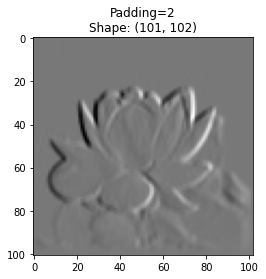

In [5]:
#@title Effect of padding { run: "auto", vertical-output: true, display-mode: "both" }

# Note:After running this cell manually, it will auto-run if you 
# change the selected value.

# Our original lotus image
image = cv2.imread('lotus.jpg', 0)


# Apply 3x3 convolution to image with given padding 1 on all 4 sides
padding = 2 #@param {type:"slider", min:1, max:20, step:1}
n = apply_conv(image, 3, padding=padding)

# Plot the results
plt.imshow(n, cmap='gray')
plt.title('Padding={}\nShape: {}'.format(padding, str(n.shape)))
plt.show()

As you observed, the output shape changes with padding. More the padding, bigger will be the image.

##### Effect of Kernel size
Change the kernel size with the slider. What do you observe?

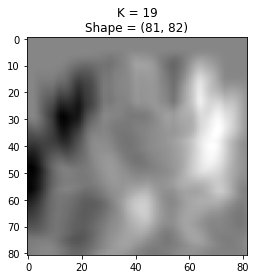

In [6]:
#@title Effect of Kernel size { run: "auto", vertical-output: true, display-mode: "both" }
# Our original lotus image
image = cv2.imread('lotus.jpg', 0)

# Apply 3x3 convolution to image
K = 19 #@param {type:"slider", min:3, max:21, step:2}
n = apply_conv(image, K)

# Plot result
plt.imshow(n, cmap='gray')
plt.title('K = {}\nShape = {}'.format(K, str(n.shape)))
plt.show()

Thus, we conclude that output image becomes blurry with increase in kernel size as summation occurs over larger neighbourhood. Smaller kernel size is used to capture details whereas larger kernel captures bigger elements in image.

##### Effect of Stride
Change the stride value with the slider. What do you observe?

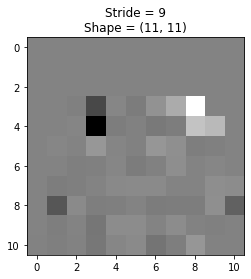

In [7]:
#@title Effect of Stride { run: "auto", vertical-output: true, display-mode: "both" }
# Our original lotus image
image = cv2.imread('lotus.jpg', 0)

# Apply 3x3 convolution to image
stride = 9 #@param {type:"slider", min:1, max:10, step:1}
n = apply_conv(image, 3, stride=stride)

# Plot result
plt.imshow(n, cmap='gray')
plt.title('Stride = {}\nShape = {}'.format(stride, str(n.shape)))
plt.show()

As we can see, the output becomes pixelated as strides increase because we have fewer values in the output by skipping pixels in input. Also, hence size of output decreases. 

### Questions

1. Does increasing stride increase output image size?

Answer) 

2. Does increasing padding increase output image size?

Answer) 

## 2. Pooling
Strides, actually downsample the image but a more robust and common approach is pooling. It may be useful when we do not require finer details but important structural elements. Here, we will see an example of max pooling and average pooling on a simple 2D image matrix. Refer [nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [nn.AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html) for the documentation.



Max Pooling & Average Pooling

Max Pooling:
 [[9. 8.]
 [7. 9.]]

Avg Pooling:
 [[2.5625 3.    ]
 [2.5625 1.9375]]



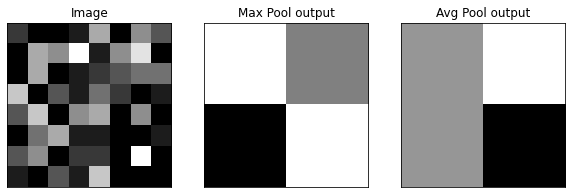

In [8]:
from torch.nn import MaxPool2d, AvgPool2d
import warnings
warnings.filterwarnings('ignore')


def plot_images(images, titles, tick_params=True):
  n = len(images)
  fig = plt.figure(figsize=(10,4))
  for i in range(n):
    ax = fig.add_subplot(1,n,i+1)
    if len(images[i].shape) == 2:
      ax.imshow(images[i], cmap='gray', 
                extent=(0,images[i].shape[1], images[i].shape[0], 0))
    else:
      ax.imshow(images[i])
    ax.set_title(titles[i])
    if not tick_params:
      plt.tick_params(axis='both', labelbottom=False, bottom=False, 
                labelleft=False, left=False)
  plt.show()


# 2D image
image = np.array([
   		[2, 0, 0, 1, 6, 0, 5, 3],
		[0, 6, 5, 9, 1, 5, 8, 0],
		[0, 6, 0, 1, 2, 3, 4, 4],
		[7, 0, 3, 1, 4, 2, 0, 1],
		[3, 7, 0, 5, 6, 0, 5, 0],
		[0, 4, 6, 1, 1, 0, 0, 1],
		[3, 5, 0, 2, 2, 0, 9, 0],
		[1, 0, 3, 1, 7, 0, 0, 0]])

# Saving output for plots
output = []
titles = []

output.append(image)
titles.append('Image')

image = torch.from_numpy(image.astype(np.float32))
input = image.view((1,1,image.shape[0], image.shape[1]))

#----------MAX POOLING LAYER--------
pool_layer = MaxPool2d(kernel_size=4, stride=4)
op = pool_layer(input)
max_output_img = op.data.numpy()  # Tensor to back in numpy
max_output_img = max_output_img.reshape((-1, max_output_img.shape[-1]))
print('Max Pooling:\n', max_output_img)
print()
output.append(max_output_img)
titles.append('Max Pool output')

#----------AVERAGE POOLING LAYER--------
pool_layer = AvgPool2d(kernel_size=4, stride=4)
op = pool_layer(input)
avg_output_img = op.data.numpy()  # Tensor to back in numpy
avg_output_img = avg_output_img.reshape((-1, avg_output_img.shape[-1]))
print('Avg Pooling:\n',avg_output_img)
print()

output.append(avg_output_img)
titles.append('Avg Pool output')

plot_images(output, titles, tick_params=False)

### Questions

1. Can you think of any other pooling other than max and avg?

Answer) 

## 3. Fine-tuning and transfer learning

Now , we will perform image classification using pretrained CNN models (transfer learning). We will understand two approaches, Fine-tuning and Feature extraction using ResNet architecture to train a model to perform traffic sign classification.

To make your task easier, we provide you the starter code to perform the lab exercises. It is expected that you should try to understand what the code does and analyze the output. We will be using Pytorch framework for the implementation of this lab. The training hyperparameters that are used in the code may not be the best to minimize training time according to lab scope. 

### German Traffic Sign classification
When a task involves training a CNN on a dataset of images, our first instinct would be to train the network from scratch. However, in practice, CNN has a huge number of parameters, often in the range of millions. Training a CNN on a small dataset greatly affects the network's ability to generalize, often resulting in overfitting.
Therefore, in practice, one would fine-tune existing networks that are trained on a large dataset like the ImageNet (1.2M labeled images) by continue training it (i.e. running back-propagation) on the smaller dataset we have. Provided that our dataset is not drastically different in context to the original dataset (e.g. ImageNet), the pre-trained model will already have learned features that are relevant to our own classification problem.  Here, we will understand the Fine-tuning and Feature extraction approach to transfer learning. In the first one, we will take a pretrained ResNet model and replace the classifier to train it on our dataset. In the second approach, we will freeze the weights of the entire network except the classifier and train it on our data. We will thus, analyse the model performance in both cases. The German Traffic Sign Recognition Benchmark (GTSRB) dataset contains 43 classes of traffic signs, with varying light conditions and rich backgrounds.

In [9]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time


In [10]:
# Device configuration (whether to run on GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
# Set seeds for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### Load German Traffic Sign dataset
To get an idea of using our own datasets with Pytorch, this time, we will not use Pytorch's builtin datasets. The dataset we will use has more than 50K samples. To make the scenario more realistic, the number of samples in each class is limited to 200 only. And we have also reduced the test set.

In [12]:
!gdown --id 1V7dt70fz_AKRJlttyjnrtFpuJDLXr15x

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1V7dt70fz_AKRJlttyjnrtFpuJDLXr15x
To: /content/german_traffic_signs_dataset.zip
100% 68.2M/68.2M [00:00<00:00, 125MB/s]


In [13]:
# Unzip
!unzip -q german_traffic_signs_dataset.zip

The dataset is stored in a folder structure where samples are separated in classwise folders. We can load the entire dataset using Pytorch's ['ImageFolder'](https://pytorch.org/vision/stable/datasets.html#ImageFolder) class. Then, we can see it like any built-in dataset. As the images are of varying shape, we will resize them to fixed dimensions (224,224) and normalize them in range [0,1]. We will here use data augmentation techniques like Gaussian blur and affine transformation to augment the data. This will increase variations in our data and help our model to generalize well.

In [14]:
transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.GaussianBlur(3),
            transforms.RandomAffine(0, translate=(0.3,0.3), shear=5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = ImageFolder('german_traffic_signs_dataset/Train', transform=transform)
testset = ImageFolder('german_traffic_signs_dataset/Test', transform=transform)

#### Train, validation and test dataloaders
We will split the trainset further to create train-validation split. We will only train on train data and evaluate the model on validation data at each step. The validation metrics helps us to understand whether model is overfitting the data or not.

In [15]:
# Shuffle and split train set into 80% training and 20% validation set
val_split = 0.2
indices = np.arange(len(trainset))
np.random.shuffle(indices)
partition = int((1-val_split)*len(trainset))

#SubsetRandomSampler will only sample examples from the given subset of data
train_loader = DataLoader(trainset, shuffle=False, sampler=SubsetRandomSampler(indices[:partition]), batch_size=64, num_workers=2)
val_loader = DataLoader(trainset, shuffle=False, sampler=SubsetRandomSampler(indices[partition:]), batch_size=64, num_workers=2)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': partition, 'val': len(train_loader.dataset) - partition}

test_loader = DataLoader(testset, shuffle=False, batch_size=64, num_workers=2)

In [16]:
# Print dataset information
print('Number of training images: ', dataset_sizes['train'])
print('Number of validation images: ', dataset_sizes['val'])
print('Number of test images: ', len(test_loader.dataset))
print('Number of classes: ', len(trainset.classes))

Number of training images:  6880
Number of validation images:  1720
Number of test images:  2000
Number of classes:  43


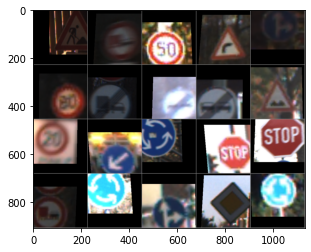

In [17]:
# Helper function to show an image
def plot_image(img):
    img = img / 2 + 0.5                         # unnormalize the image
    npimg = img.numpy()                         # torch to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # as torch image is (C, H, W)
    plt.show()


# Get some random training images from dataloader
dataiter = iter(train_loader)
images, labels = dataiter.next()

# Plot images
plot_image(torchvision.utils.make_grid(images[:20], nrow=5))

Helper functions for training/testing

In [18]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    since = time.time()

    # best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    train_acc = []
    val_losses = []
    val_acc = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Enable grads if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Running loss and correct predictions
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Save loss and acc values
            if phase == 'train':
              train_losses.append(epoch_loss)
              train_acc.append(epoch_acc)
            else:
              val_losses.append(epoch_loss)
              val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc*100))

            # Save the best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc*100))

    return train_losses, val_losses, train_acc, val_acc

In [19]:
def test_model(model, test_loader):
    model.eval()
    test_acc = 0
    correct = 0
    for i, (images, labels) in enumerate(test_loader):
      with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, preds = torch.max(output, dim=1)
        correct += (preds == labels).sum()

    test_acc = correct / len(test_loader.dataset)
    print('Test Accuracy: {:.4f}'.format(test_acc*100))


### 1. Finetuning
Here, we will load a pretrained model ResNet18 available in Pytorch and reset final fully connected layer. The model is trained on ImageNet dataset which is a large dataset containing 1000 classes.

In [20]:
# Load pretrained model
model = torchvision.models.resnet18(pretrained=True)

# Reset classifier to 43 output units (number of classes in our dataset)
model.fc = nn.Linear(model.fc.in_features, 43)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

#### Define loss function

In [21]:
# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

#### Define optimizer

In [22]:
# SGD optimizer with momentum
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#### Training

In [23]:
# Accuracy on test data before training
test_model(model, test_loader)

Test Accuracy: 2.6500


In [24]:
history = train_model(model, criterion, optimizer, dataloaders, num_epochs=6)

Epoch 0/5
----------
train Loss: 2.8319 Acc: 37.2093
val Loss: 1.6778 Acc: 71.8605

Epoch 1/5
----------
train Loss: 1.0873 Acc: 84.8692
val Loss: 0.5921 Acc: 94.4767

Epoch 2/5
----------
train Loss: 0.4191 Acc: 96.8169
val Loss: 0.2710 Acc: 98.0814

Epoch 3/5
----------
train Loss: 0.2029 Acc: 98.9535
val Loss: 0.1344 Acc: 99.1860

Epoch 4/5
----------
train Loss: 0.1212 Acc: 99.4767
val Loss: 0.0831 Acc: 99.4767

Epoch 5/5
----------
train Loss: 0.0819 Acc: 99.6512
val Loss: 0.0587 Acc: 99.7093

Training complete in 5m 17s
Best val Acc: 99.709302


Plot training plots

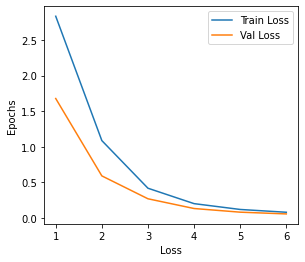

In [25]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(history[0])+1),history[0])
ax.plot(np.arange(1,len(history[1])+1),history[1])
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend(['Train Loss', 'Val Loss'])

#### Evaluate model

In [26]:
# Accuracy on test data after training
test_model(model, test_loader)

Test Accuracy: 89.5000


### 2. Feature Extraction
Here, in the second approach, we will create a new instance of network and freeze entire network parameters except the final layer. We need to set ***requires_grad == False*** to freeze the parameters so that the gradients are not computed in backward()

In [27]:
# Load pretrained model
model_conv = torchvision.models.resnet18(pretrained=True)

# Freeze all parameters
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of new classifier have requires_grad=True by default
# so grads will be computed for classifier only
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 43)

model_conv = model_conv.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Evaluate model on test data before training
print('Before training')
test_model(model_conv, test_loader)

Before training
Test Accuracy: 3.5000


####Training

In [28]:
history = train_model(model_conv, criterion, optimizer_conv, dataloaders, num_epochs=5)

Epoch 0/4
----------
train Loss: 2.3178 Acc: 41.0320
val Loss: 1.3538 Acc: 63.9535

Epoch 1/4
----------
train Loss: 1.1718 Acc: 69.6221
val Loss: 0.9744 Acc: 73.4884

Epoch 2/4
----------
train Loss: 0.9012 Acc: 76.5552
val Loss: 0.7878 Acc: 80.3488

Epoch 3/4
----------
train Loss: 0.7556 Acc: 80.3488
val Loss: 0.6553 Acc: 83.7209

Epoch 4/4
----------
train Loss: 0.6552 Acc: 83.0233
val Loss: 0.6275 Acc: 83.6628

Training complete in 4m 6s
Best val Acc: 83.720930


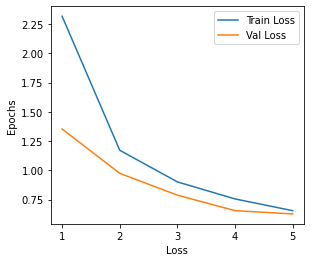

In [29]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(history[0])+1),history[0])
ax.plot(np.arange(1,len(history[1])+1),history[1])
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend(['Train Loss', 'Val Loss'])

#### Evaluate model

In [30]:
# Accuracy on test data after training
test_model(model_conv, test_loader)

Test Accuracy: 46.0000


As you can see, the test accuracy for feature extraction approach is not good compared to the first approach, although we are using pretrained models in both cases. Also, note that the training time was reduced to about half this time. This is obvious as we are not computing all the gradients this time. Experiment with the hyper-parameters like learning rate, epochs, and also optimizers till model convergence.Did you observe any improvement in the performance?

### Exercises

Q 1: Why do you think the network did not achieve good test accuracy in the feature extraction approach?

Answer: 

Q 2: Can you think of a scenario where the feature extraction approach would be preferred compared to fine tuning approach?

Answer: 

Q 3: Replace the ResNet18 architecture with some other pretrained model in pytorch and try to find the optimal parameters. Report the architecture and the final model performance.

Answer: 

Q 4: Which other data augmentations can we used to augment the data?

Answer: 

## References and Additional Resources:

*   [Transfer Learning Pytorch tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#id1)
*   [Transfer Learning with Convolutional Neural Networks in PyTorch](https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce)
*    [Torchvision models](https://pytorch.org/vision/stable/models.html)
*    [A Comprehensive Hands-on Guide to Transfer Learning with Real-World Applications in Deep Learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)

